In [2]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import itertools
import math
from matplotlib import dates as mdates

%matplotlib inline

In [18]:
!git clone https://github.com/arthuralvim/valorian-selecao-ia.git valorian

Cloning into 'valorian'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 4), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (19/19), 21.85 MiB | 7.61 MiB/s, done.


## Entrada dos Dados

Durante a leitura dos dados foram identificados algumas situações/problemas:

* ";" extras
* "," extras
* 2 elementos na mesma linha
* vários formatos para a timestamp


In [4]:
%%time

with open('/content/valorian-selecao-ia/raw/coleta.txt', 'r') as f:
    with open('coleta.csv', 'w') as fz:
        for line in f:
            line = line.strip()

            """ ; in the end lines """
            if line.endswith(";"):
                line = line[:-1]
            
            lines = [line]
            
            """ merged lines """
            if line.count(";") >= 1:
                lines = line.split(";", 1)

            for line_ in lines:
                if line_.endswith(",") and len(line_.split(",")) >= 7:
                    line_ = line[:-1]
                fz.write(line_ + '\n')

CPU times: user 1.32 s, sys: 96.1 ms, total: 1.42 s
Wall time: 1.45 s


In [5]:
%%time

column_names = ['user', 'activity', 'timestamp', 'acelerometer_x', 'acelerometer_y', 'acelerometer_z'] 

df = pd.read_csv('coleta.csv', delimiter=',',
                 names=column_names,
                 skip_blank_lines=True,
                 on_bad_lines='warn',
                 header=None,
                 encoding='utf-8',
                 verbose=True)



df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.sort_values(by=['timestamp'], ascending=True, inplace=True)
df.dropna(inplace=True)

print('Contagem NAs: ', df.isnull().sum().sum())
print('Checando se o índice é monotônico: ', df["timestamp"].is_monotonic_increasing)

Tokenization took: 43.31 ms
Type conversion took: 25.98 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 34.31 ms
Type conversion took: 24.43 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 29.95 ms
Type conversion took: 23.73 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 25.91 ms
Type conversion took: 20.91 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 25.40 ms
Type conversion took: 22.02 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 25.45 ms
Type conversion took: 20.71 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 24.71 ms
Type conversion took: 19.82 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 24.56 ms
Type conversion took: 18.19 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 9.51 ms
Type conversion took: 8.11 ms
Parser memory cleanup took: 0.00 ms
Contagem NAs:  0
Checando se o índice é monotônico:  True
CPU times: user 1.11 s, sys: 103 ms, total: 1.21 s
Wall time: 1.21 s


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098208 entries, 882381 to 1052825
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   user            1098208 non-null  int64         
 1   activity        1098208 non-null  object        
 2   timestamp       1098208 non-null  datetime64[ns]
 3   acelerometer_x  1098208 non-null  float64       
 4   acelerometer_y  1098208 non-null  float64       
 5   acelerometer_z  1098208 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 58.7+ MB


In [7]:
df.head()

,user,activity,timestamp,acelerometer_x,acelerometer_y,acelerometer_z
882381,3,Walking,1970-01-01,0.0,0.0,0.0
165028,6,Jogging,1970-01-01,0.0,0.0,0.0
165029,6,Jogging,1970-01-01,0.0,0.0,0.0
165030,6,Jogging,1970-01-01,0.0,0.0,0.0
165062,6,Jogging,1970-01-01,0.0,0.0,0.0


In [8]:
df.tail()

,user,activity,timestamp,acelerometer_x,acelerometer_y,acelerometer_z
1052821,7,Sitting,1970-01-03 10:09:57.161469,-6.74,-3.21,6.63
1052822,7,Sitting,1970-01-03 10:09:57.201539,-6.85,-3.26,6.63
1052823,7,Sitting,1970-01-03 10:09:57.241517,-6.85,-3.30,6.66
1052824,7,Sitting,1970-01-03 10:09:57.321687,-7.01,-3.17,6.36
1052825,7,Sitting,1970-01-03 10:09:57.361451,-6.85,-2.87,6.51


In [9]:
df[df.isna().any(axis=1)]

,user,activity,timestamp,acelerometer_x,acelerometer_y,acelerometer_z


Após o tratamento os tipos dos dados ficaram corretos e resultaram em 1.098.208 exemplos válidos. Foi descartado um exemplo cujo valor `acelerometer_z` era NA.

## Análise sobre o Dataset

### Sobre o *Timestamp*

Os dados estão espalhados numa janela de 2 dias e 10 horas.

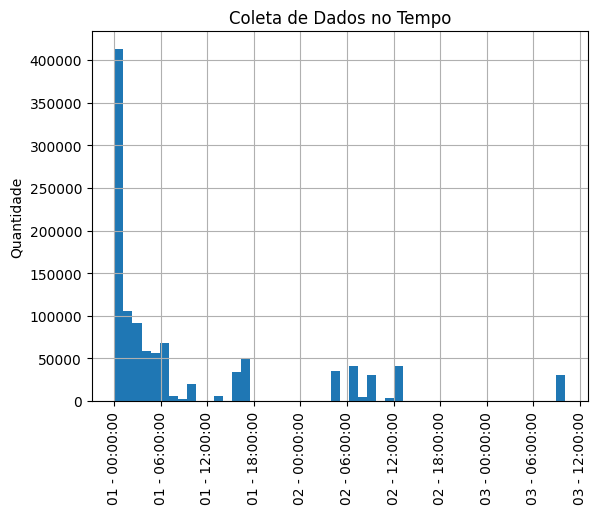

In [19]:
ax = df['timestamp'].hist(bins=50);
plt.xticks(rotation='vertical')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d - %H:%M:%S"))
plt.title("Coleta de Dados no Tempo")
plt.ylabel("Quantidade")
plt.show()

In [35]:
df['timestamp'].max() - df['timestamp'].min()

Timedelta('2 days 10:09:57.361451')

### Sobre os usuários

In [31]:
sobre_user = df[["user", "activity"]].groupby(["user"]).agg({'activity': ['nunique', 'count']})

In [33]:
sobre_user["activity"]["nunique"].value_counts()

6    19
4    10
5     4
2     2
1     1
Name: nunique, dtype: int64

Temos informações de 36 usuários cuja maioria tem dados de pelo 4 categorias das 6 disponíveis ("Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing").

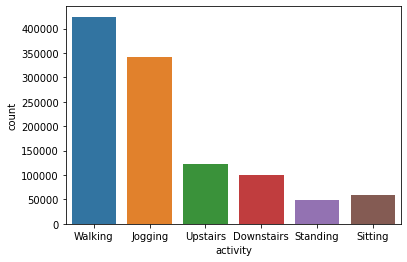

In [39]:
sns.countplot(x='activity', data=df);

In [40]:
df["activity"].value_counts(normalize=True)

Walking       0.386447
Jogging       0.311579
Upstairs      0.111881
Downstairs    0.091446
Sitting       0.054579
Standing      0.044067
Name: activity, dtype: float64

Notadamente temos um viés para a classe "Walking".

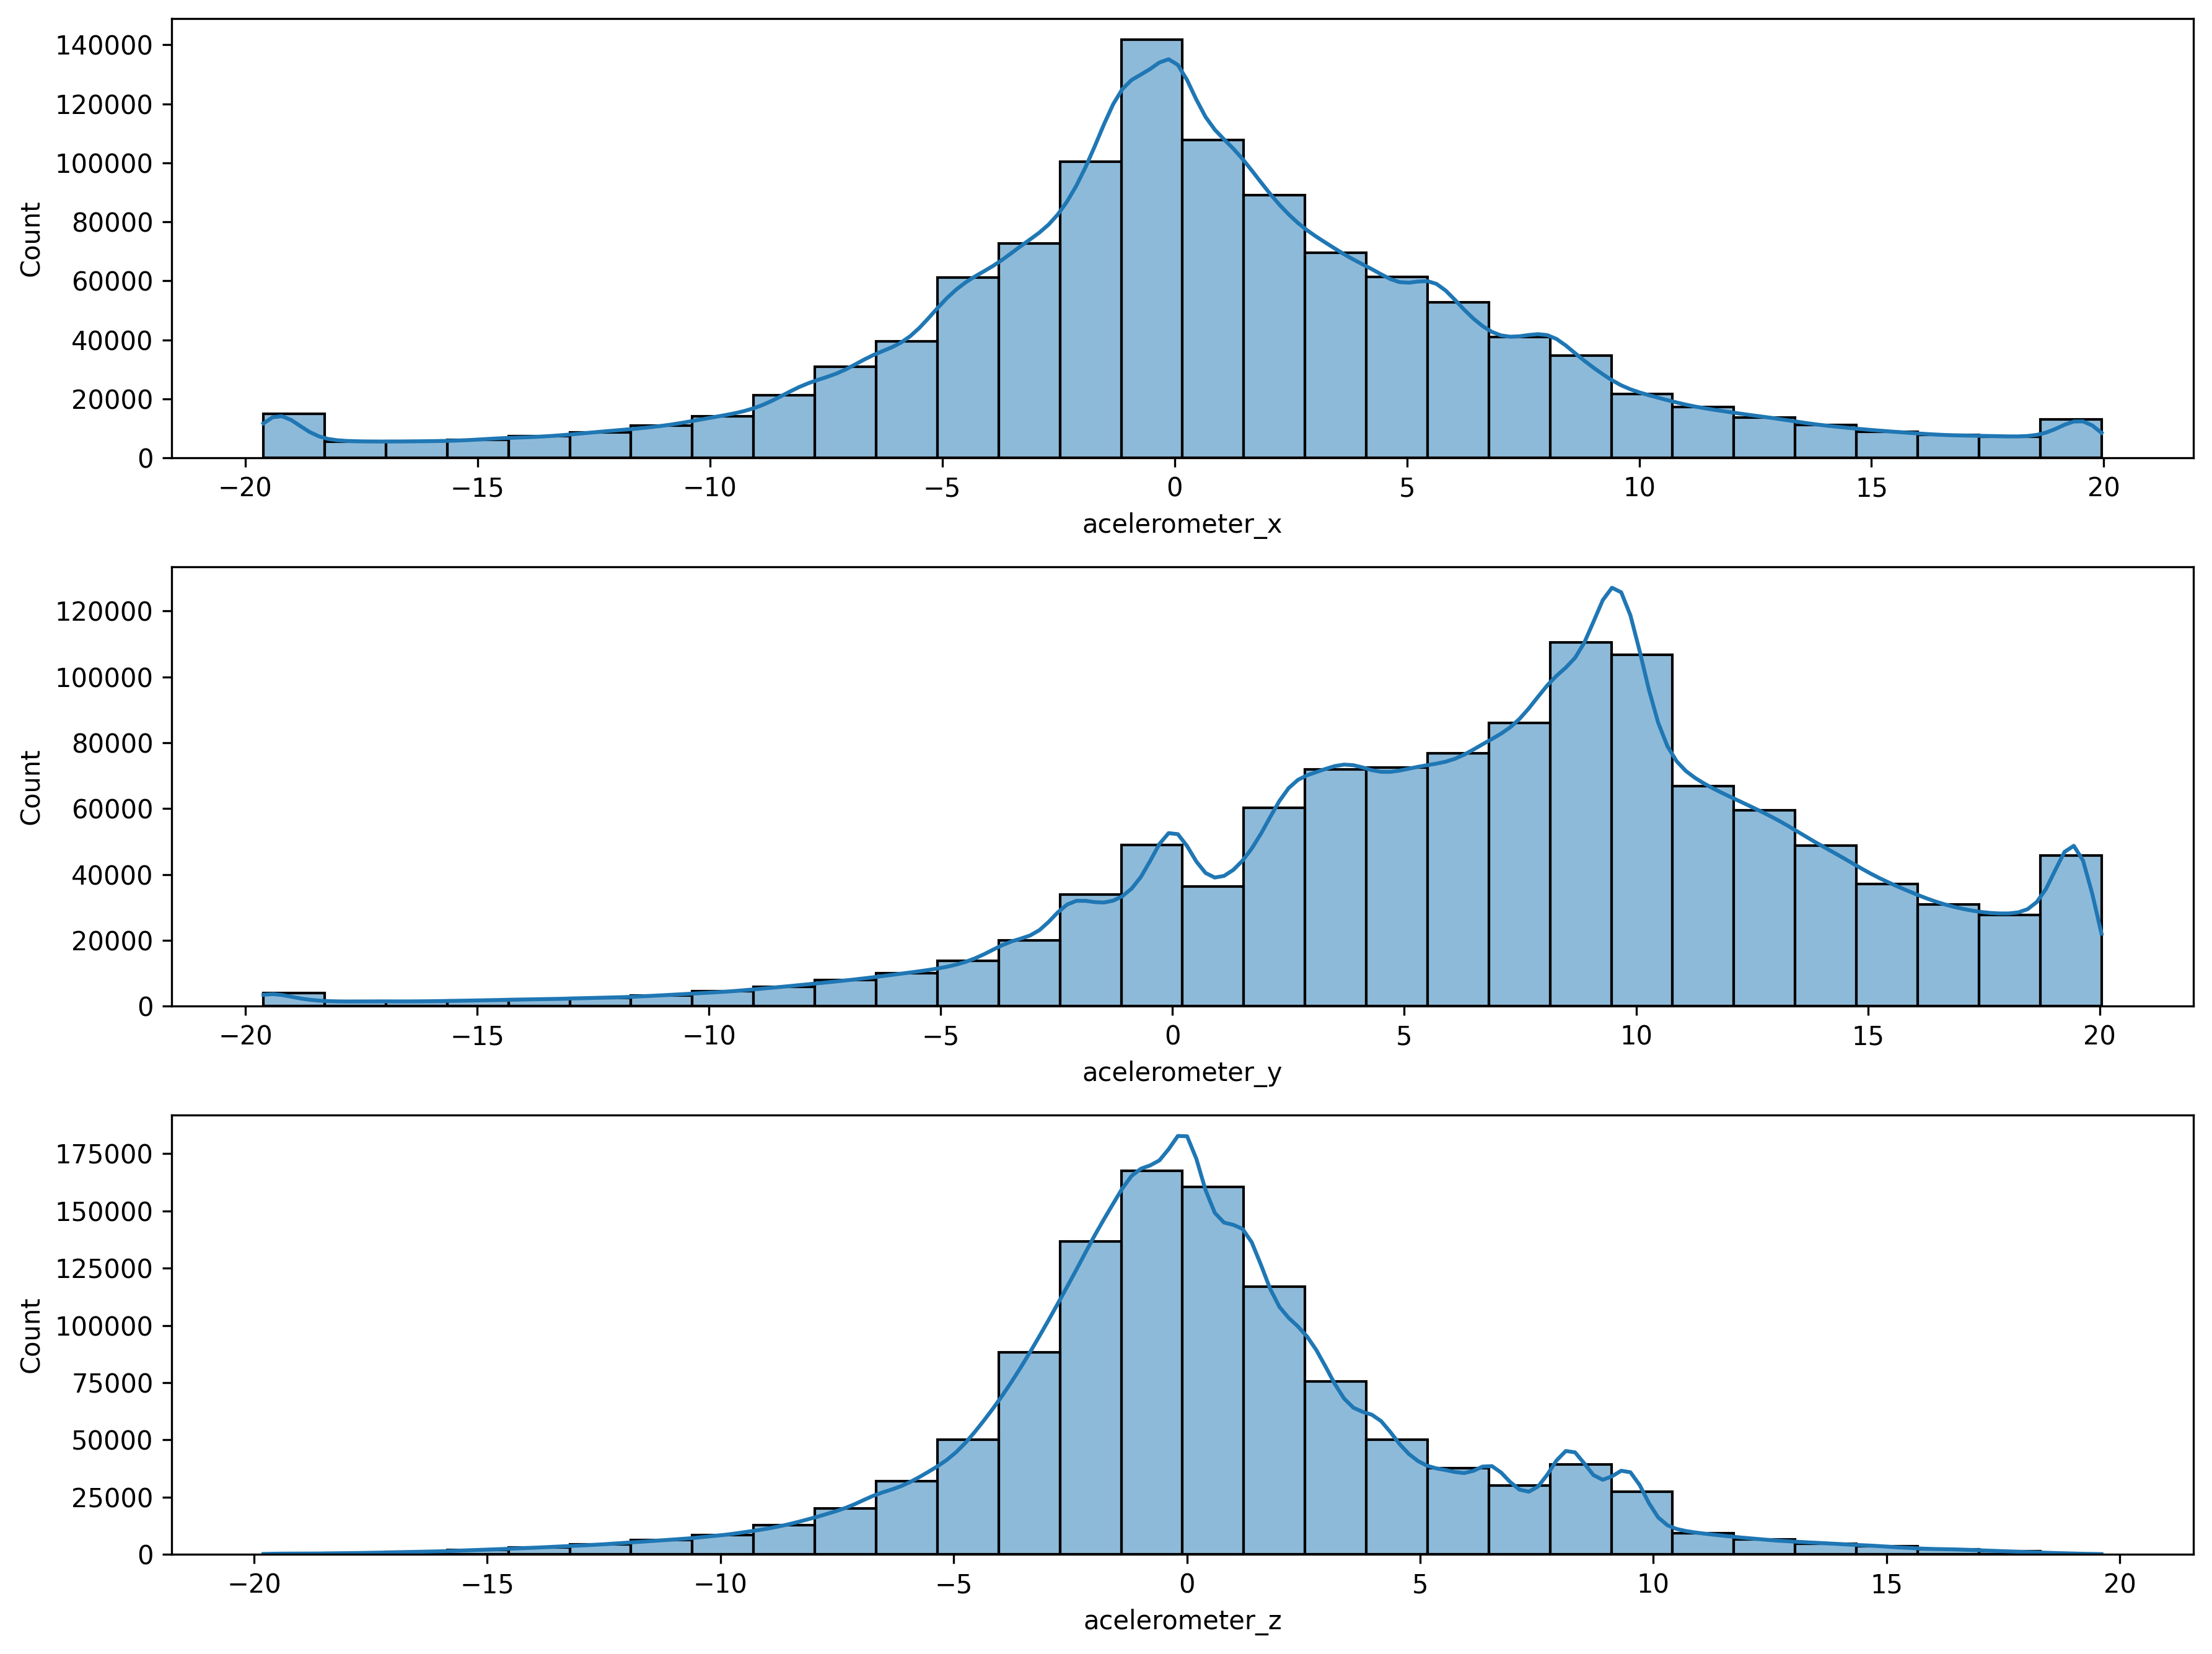

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), dpi=300)
axes = axes.flatten()

for ax, col in zip(axes, ["acelerometer_x", "acelerometer_y", "acelerometer_z",]):
  sns.histplot(df[col], ax=ax, bins=30, kde=True)

plt.tight_layout()
plt.show()

## Geração do Novo Conjunto de Dados

Foi sugerido dados a serem usados nos modelos considerassem janelas de 3 segundos com sobreposição de 75%.

In [47]:
def time_window_limits(min_limit=None, max_limit=None, unit='seconds', size=3, overlap=0.75):
    assert overlap > 0 and overlap <= 1
    delta = {unit: size * overlap}
    datetime_reference = min_limit
    while datetime_reference < max_limit:
        yield datetime_reference, datetime_reference + timedelta(**delta)
        datetime_reference = datetime_reference + timedelta(**delta)


def df_span(df, span_min, span_max):
    mask = (df['timestamp'] > span_min) & (df['timestamp'] <= span_max)
    return df.loc[mask]

df_time_window_limits = list(time_window_limits(min_limit=df["timestamp"].min(), max_limit=df["timestamp"].max()))

In [48]:
%%time

pickle_path = '/content/valorian/coleta-processed.pkl'
force_regenerate = False

if os.path.exists(pickle_path) and not(force_regenerate):
    final_df = pd.read_pickle(pickle_path)
else:
  final_column_names = ['timestamp_min', 'timestamp_max', 'acelerometer_x', 'acelerometer_y', 'acelerometer_z', 'target']
  data = []

  for name, group in df.groupby('activity'):
      for span_min, span_max in df_time_window_limits:
          filtered_group = df_span(group, span_min, span_max)

          if filtered_group.empty:
              continue

          metrics = filtered_group[["acelerometer_x", "acelerometer_y", "acelerometer_z"]].mean().tolist()
          data.append([span_min, span_max] + metrics + [name])

  final_df = pd.DataFrame(data, columns=final_column_names)
  final_df.to_pickle("coleta-processed.pkl")


CPU times: user 16min 39s, sys: 2.38 s, total: 16min 41s
Wall time: 17min 36s


O código acima em resumo:
* Gera os intervalos dos limites das janelas de 3 segundos com 75% de sobreposição.
* Em seguida para cada categoria de atividade, ele filtra e agrega os dados para cada intervalo gerando um novo exemplo.
* Para os dados relativos a acelerômetro usei a média como função de agregação apesar de não saber se seria o mais adequado.
* Em média o processo tomou cerca de 25 min para geração do novo dataset. Para facilitar a importação no caderno onde ficarão os modelos causa foi criado um pickle.

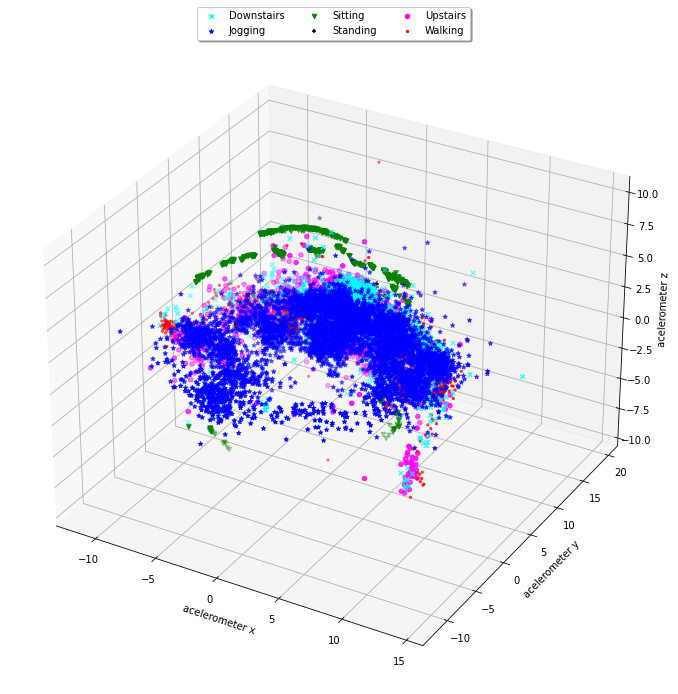

CPU times: user 615 ms, sys: 174 ms, total: 789 ms
Wall time: 623 ms


In [52]:
%%time

COLORS_MARKERS_DICT = {
    'Walking': ['red', '.'],
    'Jogging': ['blue', '*'],
    'Upstairs': ['magenta', 'o'],
    'Downstairs': ['cyan', 'x'],
    'Sitting': ["green", 'v'],
    'Standing': ["black", '+'],
}

def plot3d(df, targets, fields=["acelerometer_x", "acelerometer_y", "acelerometer_z"]):


    fig = plt.figure(figsize=(12, 12))
    axes = fig.add_subplot(111, projection='3d')
    
    for g in np.unique(targets):
        df_target = df[targets == g]
        axes.scatter(df_target["acelerometer_x"], 
                     df_target["acelerometer_y"], 
                     df_target["acelerometer_z"],
                     label=g, color=COLORS_MARKERS_DICT[g][0], marker=COLORS_MARKERS_DICT[g][1])

    axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)

    axes.set_xlabel('acelerometer x')
    axes.set_ylabel('acelerometer y')
    axes.set_zlabel('acelerometer z')
    
    plt.show()

plot3d(df=final_df, targets=final_df["target"])

Acima temos uma tentativa de resultado visual da nova base gerada que agora possui de 19721 exemplos.

Para o futuro:

* Entender melhor do domínio em questão.
* Seria interessante enxergar um recorte de cada atividades no tempo afim de identificar horários propicios a cada práticas.
* Melhorar a performance e as funções de janela.